In [1]:
from PIL import Image
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

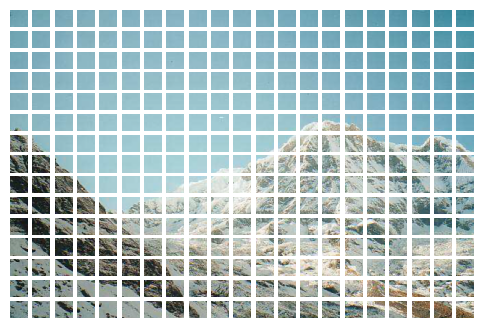

In [2]:
# 이미지 읽기, 파라미터 설정
image = cv2.imread('annapurna_left_01.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
width = 31
height = 31
stride = 31

def make_patches(image, width, height, stride):
  patches = list()
  keypoints = list()
  H, W, _ = image.shape

# 패치를 자르는 알고리즘 구성
  for h_i in range(0, H-height+1, stride):
    for w_i in range(0, W-width+1, stride):
      # 패치 슬라이싱
      patch = image[h_i:h_i+height, w_i:w_i+width]

      # w_i와 h_i를 이용하여 패치 중앙점의 좌표 구하기
      center_x = w_i + width // 2
      center_y = h_i + height // 2

     # cv2.KeyPoint 객체 생성
      keypoint = cv2.KeyPoint(center_x, center_y, size=(width+height / 2.0))

      patches.append(patch)
      keypoints.append(keypoint)

  return patches, keypoints

patches, keypoints = make_patches(image, width, height, stride)

# 결과 출력
def plot_patches(patches, num_columns=21):
  num_patches = len(patches)
  num_rows = int(np.ceil(num_patches / num_columns))
  fig, axes = plt.subplots(num_rows, num_columns, figsize=(6,4))
  axes = axes.ravel()

  for i in range(num_patches):
    axes[i].imshow(patches[i])
    axes[i].axis('off')

# 남은 빈 칸 처리
  for i in range(num_patches, len(axes)):
    axes[i].axis('off')

  plt.subplots_adjust(wspace=0.2, hspace=0.2)
  plt.show()

plot_patches(patches)

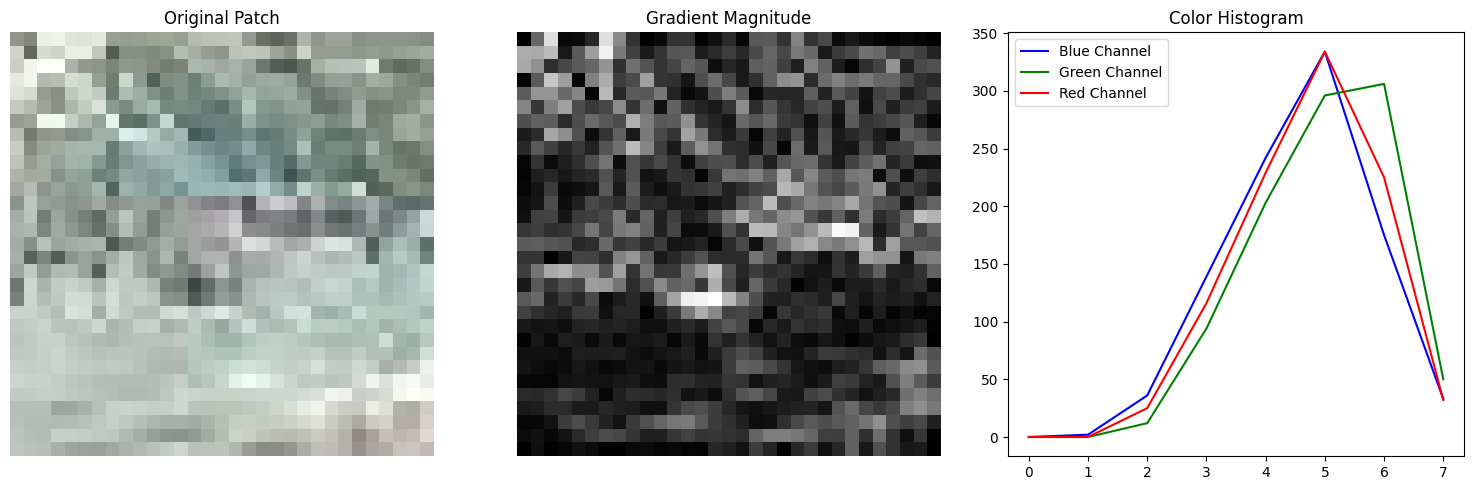

In [3]:
def extract_gradients(patch):
  # 주어진 이미지(패치)의 gradient를 구하는 알고리즘 구성
  gray = cv2.cvtColor(patch, cv2.COLOR_RGB2GRAY)

  # X, Y 방향의 gradient 계산
  grad_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
  grad_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)

  # 크기와 방향 계산
  magnitude = cv2.magnitude(grad_x, grad_y)
  angle = cv2.phase(grad_x, grad_y, angleInDegrees=True)

  grads, _ = np.histogram(angle, bins=8, range=(0, 360), weights=magnitude)

  return magnitude, grads

def extract_color_histogram(patch):
  # 패치의 컬러 히스토그램 계산(각 채널)
  hist_b = cv2.calcHist([patch], [0], None, [8], [0, 256])
  hist_g = cv2.calcHist([patch], [1], None, [8], [0, 256])
  hist_r = cv2.calcHist([patch], [2], None, [8], [0, 256])

  hists = np.concatenate((hist_b, hist_g, hist_r)).flatten()

  return hists


# 결과 확인
patch = patches[220]

magnitude, grad_desc = extract_gradients(patch)
color_hist_desc = extract_color_histogram(patch)

fig, axes = plt.subplots(1, 3, figsize=(15,5))

axes[0].imshow(patch)
axes[0].set_title("Original Patch")
axes[0].axis('off')

axes[1].imshow(magnitude, cmap='gray')
axes[1].set_title("Gradient Magnitude")
axes[1].axis('off')

axes[2].plot(color_hist_desc[:8], color='b', label="Blue Channel")
axes[2].plot(color_hist_desc[8:16], color='g', label="Green Channel")
axes[2].plot(color_hist_desc[16:], color='r', label="Red Channel")
axes[2].set_title("Color Histogram")
axes[2].legend()

plt.tight_layout()
plt.show()


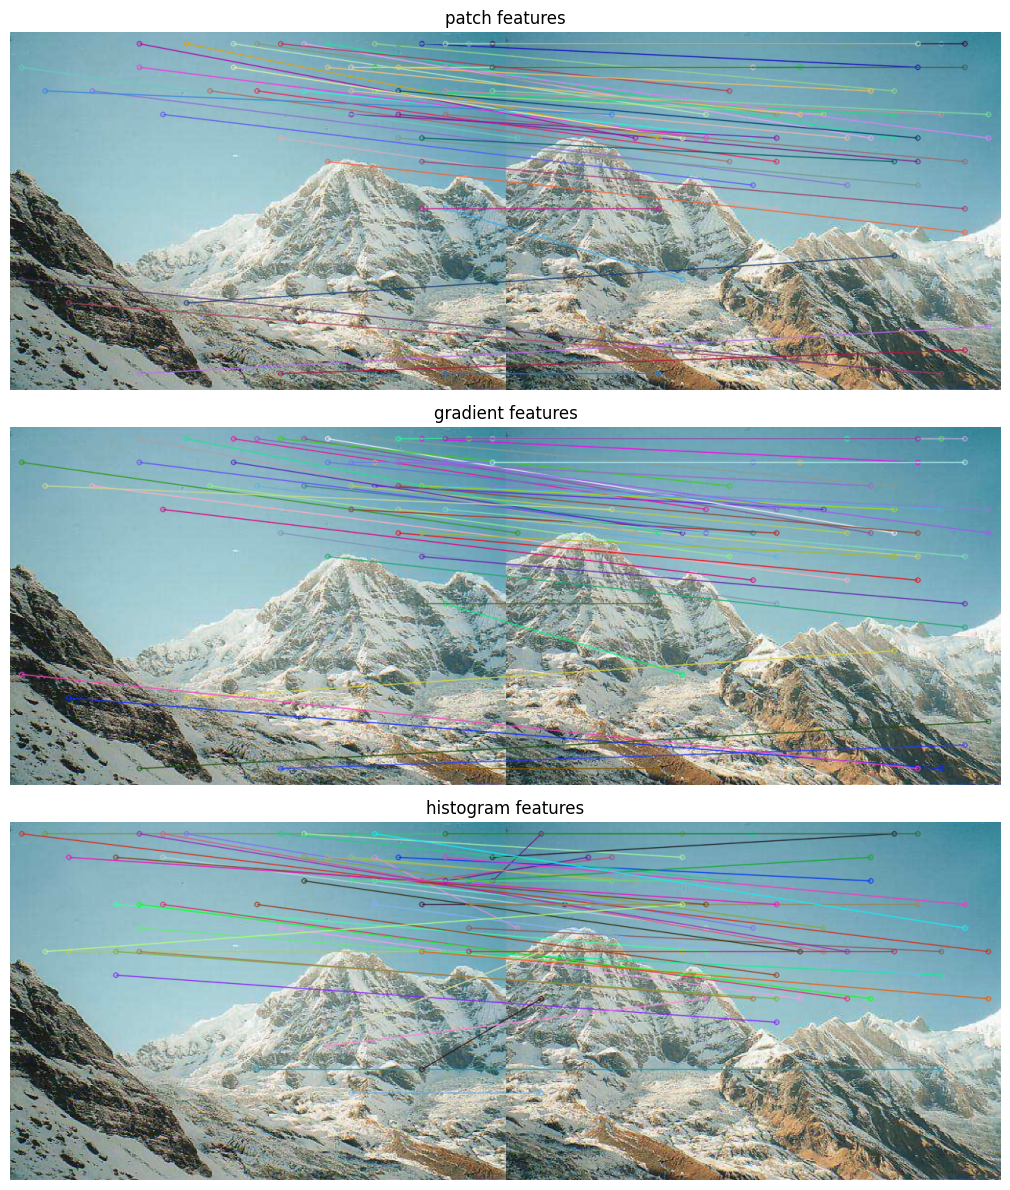

In [4]:
# 페어 이미지 읽고 패치 추출하기
image_01 = cv2.imread('annapurna_left_01.png')
image_02 = cv2.imread('annapurna_right_01.png')
image_01 = cv2.cvtColor(image_01, cv2.COLOR_BGR2RGB)
image_02 = cv2.cvtColor(image_02, cv2.COLOR_BGR2RGB)

width = 31
height = 31
stride = 31

patches_01, kp1 = make_patches(image_01, width, height, stride)
patches_02, kp2 = make_patches(image_02, width, height, stride)

# 추출한 패치들을 이용하여 디스크립터 추출
patch_features_01 = list()
gradients_01 = list()
histograms_01 = list()
for patch in patches_01:
  # 그라디언트와 컬러 히스토그램 추출
  patch_feature = patch.flatten()
  _, grad = extract_gradients(patch)
  hist = extract_color_histogram(patch)

  patch_features_01.append(np.array(patch_feature, dtype=np.float32))
  gradients_01.append(np.array(grad, dtype=np.float32))
  histograms_01.append(np.array(hist, dtype=np.float32))

# 두번째 이미지에 대해서도 동일하게 추출
patch_features_02 = list()
gradients_02 = list()
histograms_02 = list()
for patch in patches_02:
  patch_feature = patch.flatten()
  _, grad = extract_gradients(patch)
  hist = extract_color_histogram(patch)

  patch_features_02.append(np.array(patch_feature, dtype=np.float32))
  gradients_02.append(np.array(grad, dtype=np.float32))
  histograms_02.append(np.array(hist, dtype=np.float32))

# 추출된 특징을 이용하여 매칭 수행
# patch feature 매칭
matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
matches_patch = matcher.match(np.array(patch_features_01), np.array(patch_features_02))
matches_patch = sorted(matches_patch, key=lambda x: x.distance)[:50]

# gradient feature 매칭
matches_grad = matcher.match(np.array(patch_features_01), np.array(patch_features_02))
matches_grad = sorted(matches_grad, key=lambda x: x.distance)[:50]

# histogram feature 매칭
matches_hist = matcher.match(np.array(histograms_01), np.array(histograms_02))
matches_hist = sorted(matches_hist, key=lambda x: x.distance)[:50]


def plot_matches_in_subplot(ax, img1, img2, kp1, kp2, matches, title):
    draw_image = cv2.drawMatches(img1, kp1, img2, kp2, matches, None,
                                  flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    ax.imshow(draw_image)
    ax.set_title(title)
    ax.axis('off')

# 각 매칭 결과 출력
fig, axs = plt.subplots(3, 1, figsize=(18, 12))

plot_matches_in_subplot(axs[0], image_01, image_02, kp1, kp2, matches_patch, "patch features")
plot_matches_in_subplot(axs[1], image_01, image_02, kp1, kp2, matches_grad, "gradient features")
plot_matches_in_subplot(axs[2], image_01, image_02, kp1, kp2, matches_hist, "histogram features")

plt.tight_layout()
plt.show()

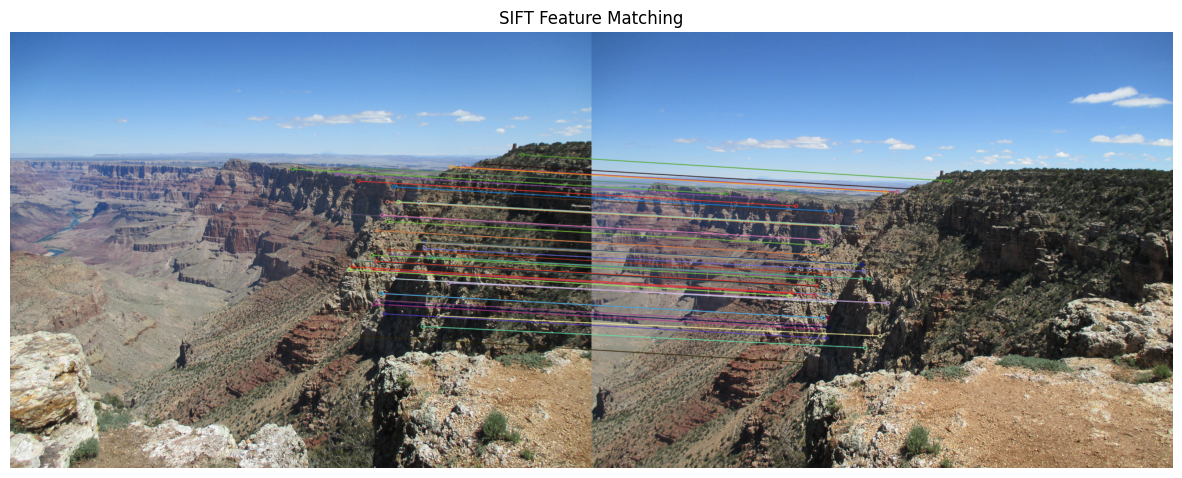

In [5]:
image_01 = cv2.imread('grand_canyon_left_01.png')
image_02 = cv2.imread('grand_canyon_right_01.png')
image_01 = cv2.cvtColor(image_01, cv2.COLOR_BGR2RGB)
image_02 = cv2.cvtColor(image_02, cv2.COLOR_BGR2RGB)

# SIFT 디스크립터 추출
sift = cv2.SIFT_create()

kp1, desc1 = sift.detectAndCompute(image_01, None)
kp2, desc2 = sift.detectAndCompute(image_02, None)

# 브루트포스 매칭
matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
matches = matcher.match(desc1, desc2)

# 거리 기준으로 정렬, 상위 50개 매칭 선택
matches = sorted(matches, key=lambda x: x.distance)[:50]

# 결과 출력
def plot_sift_matches(img1, img2, kp1, kp2, matches, title="SIFT Feature Matching"):
    draw_image = cv2.drawMatches(img1, kp1, img2, kp2, matches, None,
                                  flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.figure(figsize=(15, 10))
    plt.imshow(draw_image)
    plt.title(title)
    plt.axis('off')
    plt.show()

plot_sift_matches(image_01, image_02, kp1, kp2, matches)

In [6]:
# paired 이미지 불러오기
image_01 = cv2.imread('annapurna_left_01.png')
image_02 = cv2.imread('annapurna_right_01.png')
image_01 = cv2.cvtColor(image_01, cv2.COLOR_BGR2RGB)
image_02 = cv2.cvtColor(image_02, cv2.COLOR_BGR2RGB)

# SIFT 디스크립터 정의
descriptor = cv2.SIFT_create()

# Keypoint와 특징 추출
keypoints_01, features_01 = descriptor.detectAndCompute(image_01, None)
keypoints_02, features_02 = descriptor.detectAndCompute(image_02, None)

# 매칭 수행
matcher = cv2.BFMatcher(cv2.NORM_L2)
raw_matches = matcher.knnMatch(features_02, features_01, k=2)

good_matches = []
ratio_thresh = 0.7
for m, n in raw_matches:
    if m.distance < ratio_thresh * n.distance:
        good_matches.append(m)

# 매칭 포인트 구하기
# m은 두 이미지의 매칭된 키포인트 쌍을 나타냄
# keypoints_01은 소스 이미지에서 추출한 SIFT 키포인트 리스트, keypoints_02는 대상 이미지에서 추출한 키포인트 리스트
# 각 키포인트는 .pt 속성을 통해 (x, y) 좌표를 얻을 수 있다.
# .queryIdx : 매칭 시 소스 이미지의 키포인트 인덱스
# .trainIdx : 매칭 시 대상 이미지의 키포인트 인덱스
src_points = np.float32([keypoints_02[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
dst_points = np.float32([keypoints_01[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

# 위 결과로 Homography 행렬을 구합니다.
H, ok = cv2.findHomography(src_points, dst_points, method=0)

print("SVD Homography matrix:")
print(H)

SVD Homography matrix:
[[ 5.87591391e-01  1.32636712e-01  3.27519202e+02]
 [-2.84559812e-01  8.61798827e-01  6.53275867e+01]
 [-5.86426508e-04 -8.10275437e-05  1.00000000e+00]]


In [7]:
# RANSAC을 이용하여 Homography 행렬 구하기
H, ok = cv2.findHomography(src_points, dst_points, method=cv2.RANSAC, ransacReprojThreshold=5.0)
print("RANSAC Homography Matrix:")
print(H)

RANSAC Homography Matrix:
[[ 5.86614390e-01  1.27387733e-01  3.27707371e+02]
 [-2.81193840e-01  8.54439691e-01  6.61003158e+01]
 [-5.77644614e-04 -9.43167655e-05  1.00000000e+00]]


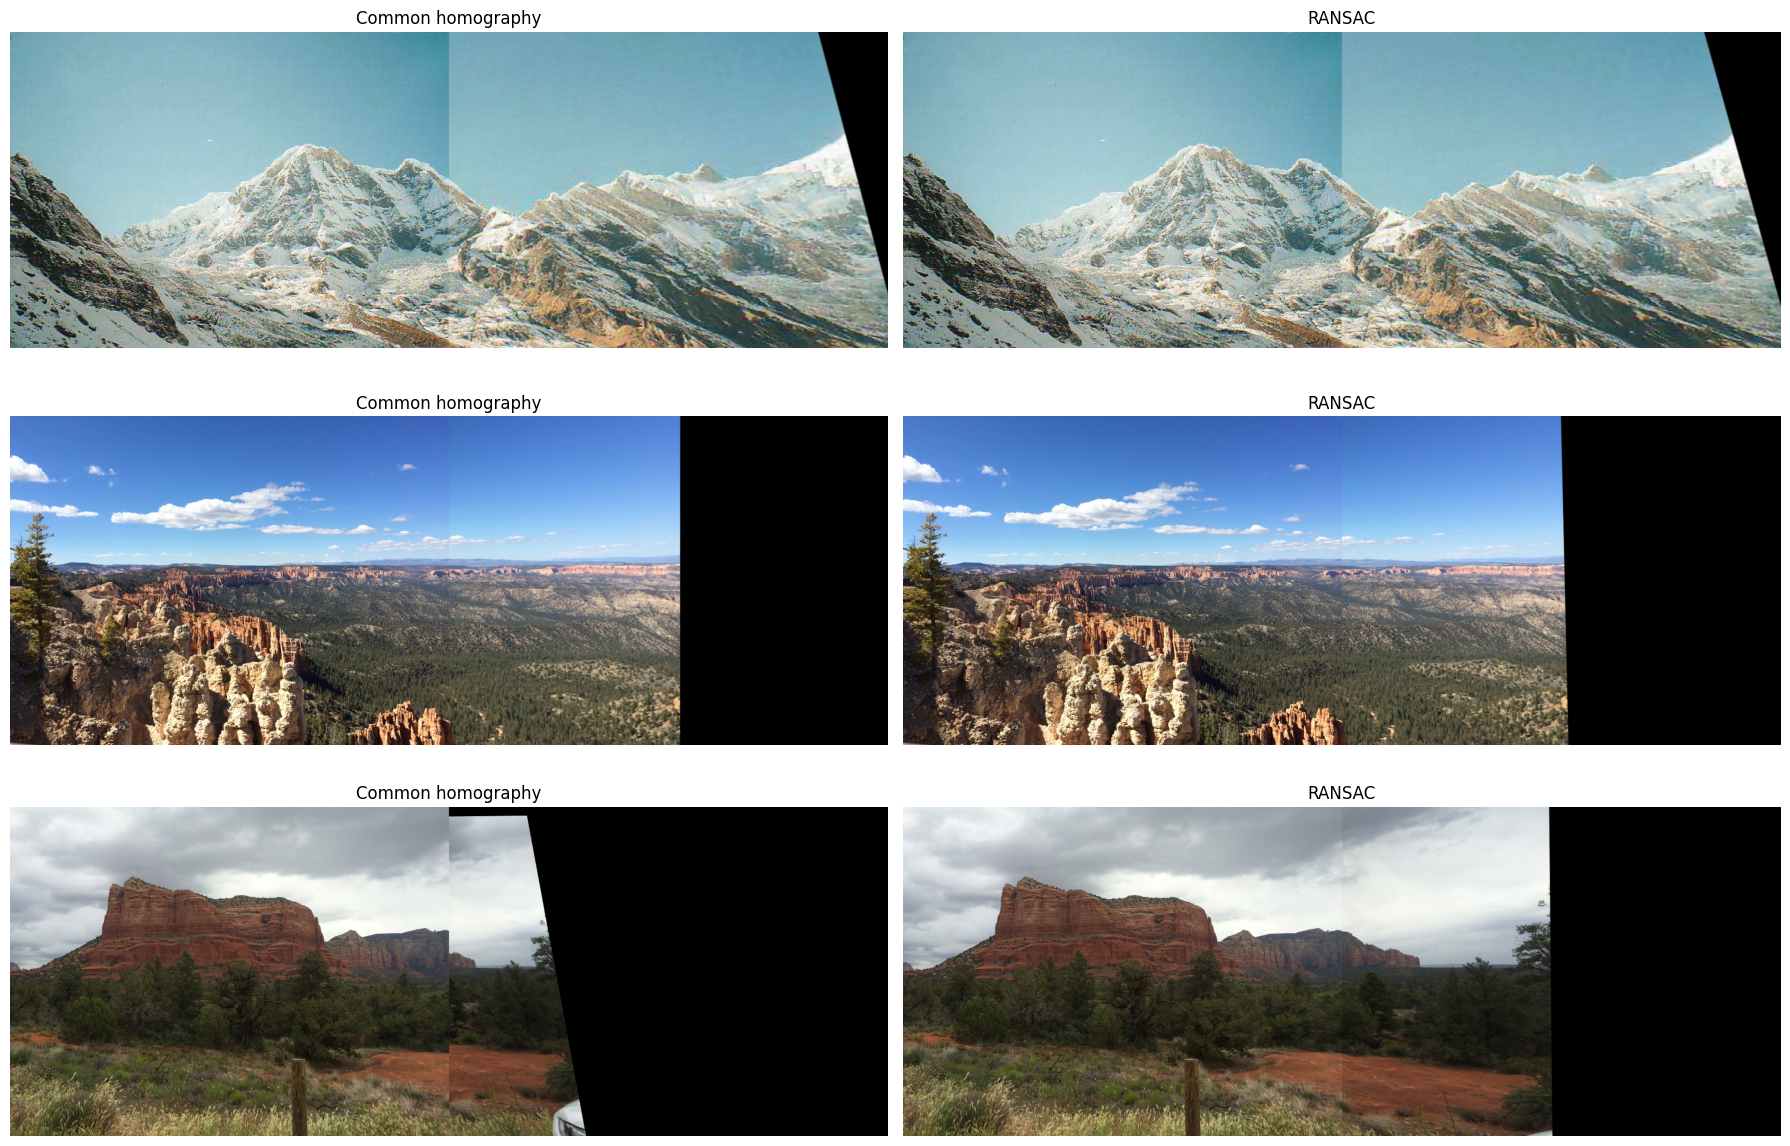

In [9]:
def calculate_homography_and_stitch(image1, image2):
    # SIFT를 이용하여 키포인트, 디스크립터 작성
    sift = cv2.SIFT_create()
    k_01, f_01 = sift.detectAndCompute(image1, None)
    k_02, f_02 = sift.detectAndCompute(image2, None)

    # 이미지 매칭 수행
    matcher = cv2.BFMatcher(cv2.NORM_L2)
    matches = matcher.knnMatch(f_02, f_01, k=2)

    good_matches = []
    ratio_thresh = 0.7
    for m, n in matches:
        if m.distance < ratio_thresh * n.distance:
            good_matches.append(m)

    # src_points, dst_points 좌표 추출
    src_points = np.float32([k_02[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_points = np.float32([k_01[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    # 2-1: 일반 Homography 행렬 계산
    # 오른쪽 이미지를 왼쪽에 붙일 수 있도록 변형
    common_H, _ = cv2.findHomography(src_points, dst_points, method=0)

    # 2-2: RANSAC Homography 행렬 계산
    # 오른쪽 이미지를 왼쪽에 붙일 수 있도록 변형
    RANSAC_H, _ = cv2.findHomography(src_points, dst_points, method=cv2.RANSAC, ransacReprojThreshold=5.0)

    # 이미지 스티칭 함수 정의
    def stitch_images(image1, image2, H):
        # height, width 변수 정의
        height, width = image1.shape[:2]

        # 오른쪽 이미지를 H 행렬을 이용해 변형
        result = cv2.warpPerspective(image2, H, (width*2, height))

        # 왼쪽 이미지를 그대로 출력
        result[0:height, 0:width] = image1
        return result

    # 2-1: 일반 Homography 행렬로 스티칭
    common_stitched_image = stitch_images(image1, image2, common_H)

    # 2-2: RANSAC Homography 행렬을 이용한 스티칭
    ransac_stitched_image = stitch_images(image1, image2, RANSAC_H)

    return common_stitched_image, ransac_stitched_image


# 이미지 불러오기
image_pairs = [
    (cv2.imread('annapurna_left_01.png'), cv2.imread('annapurna_right_01.png')),
    (cv2.imread('bryce_left_01.png'), cv2.imread('bryce_right_01.png')),
    (cv2.imread('sedona_left_01.png'), cv2.imread('sedona_right_01.png'))
]

# RGB 변환
image_pairs = [(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB), cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)) for img1, img2 in image_pairs]

# 각 이미지 쌍마다 스티칭
common_results = []
ransac_results = []
for img1, img2 in image_pairs:
    common_stitched_image, ransac_stitched_image = calculate_homography_and_stitch(img1, img2)
    common_results.append(common_stitched_image)
    ransac_results.append(ransac_stitched_image)

# 결과 출력
fig, axes = plt.subplots(3, 2, figsize=(18, 12))

for i in range(len(image_pairs)):
    axes[i, 0].imshow(common_results[i])
    axes[i, 0].set_title("Common homography")
    axes[i, 0].axis('off')

    axes[i, 1].imshow(ransac_results[i])
    axes[i, 1].set_title("RANSAC")
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

In [14]:
def my_calculate_homography(src_pts, dst_pts):
    A_matrix = []
    for i in range(len(src_pts)):
        x, y = src_pts[i][0], src_pts[i][1]
        xp, yp = dst_pts[i][0], dst_pts[i][1]
        A_matrix.append([-x, -y, -1, 0, 0, 0, x * xp, y * xp, xp])
        A_matrix.append([0, 0, 0, -x, -y, -1, x * yp, y * yp, yp])

    A_matrix = np.array(A_matrix)

    # SVD로 Homography 계산
    U, S, Vt = np.linalg.svd(A_matrix)
    H = Vt[-1].reshape(3, 3)
    return H / H[2, 2]


def my_ransac_homography(matches, keypoints_1, keypoints_2, threshold=5.0, max_iterations=1000):
    best_Homography = None
    best_inliers = 0
    n_points = 4  # 4쌍의 포인트 필요

    src_points = np.float32([keypoints_1[m.queryIdx].pt for m in matches])
    dst_points = np.float32([keypoints_2[m.trainIdx].pt for m in matches])

    # max_iterations 수만큼 반복
    for _ in range(max_iterations):
        # 랜덤하게 4개의 포인트 pair 선택
        idx = np.random.choice(len(src_points), n_points, replace=False)
        src_sample = src_points[idx].reshape(-1, 2)
        dst_sample = dst_points[idx].reshape(-1, 2)

        # 위 샘플로부터 Homography 행렬 계산
        try:
            Homography = my_calculate_homography(src_sample, dst_sample)
        except np.linalg.LinAlgError:
            continue

        # 재투영 오류 계산
        src_points_homogeneous = np.concatenate([src_points, np.ones((src_points.shape[0], 1))], axis=1)
        projected_points = (Homography @ src_points_homogeneous.T).T
        projected_points /= projected_points[:, 2:3]
        errors = np.linalg.norm(dst_points - projected_points[:, :2], axis=1)

        # 재투영 오류가 threshold보다 작은 점은 inlier로 간주
        inliers = errors < threshold
        n_inliers = np.sum(inliers)

        # 현재 inlier 수가 가장 많으면, 최적의 Homography와 inliers 수 갱신
        if n_inliers > best_inliers:
            best_inliers = n_inliers
            best_Homography = Homography

    # 최적의 Homography 계산을 위해 best inliers만 사용하여 최종 Homography 계산
    final_src_inliers = src_points[inliers]
    final_dst_inliers = dst_points[inliers]

    if len(final_src_inliers) < 4 or len(final_dst_inliers) < 4:
        raise ValueError("마지막 매트릭스 계산에 부족")

    Homography_final = my_calculate_homography(final_src_inliers, final_dst_inliers)
    return Homography_final


# 아래 코드는 2-1 및 2-2 단계에서의 matches와 keypoints를 사용하여 my_ransac_homography 함수를 호출하는 코드

# 매칭을 위해 이미지 불러오기 및 SIFT 키포인트와 디스크립터 추출
image1 = cv2.imread('annapurna_left_01.png')
image2 = cv2.imread('annapurna_right_01.png')
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

sift = cv2.SIFT_create()
k_01, f_01 = sift.detectAndCompute(image1, None)
k_02, f_02 = sift.detectAndCompute(image2, None)

# 매칭 수행 (KNN 매칭 + 비율 테스트)
matcher = cv2.BFMatcher(cv2.NORM_L2)
matches = matcher.knnMatch(f_02, f_01, k=2)

good_matches = []
ratio_thresh = 0.7
for m, n in matches:
    if m.distance < ratio_thresh * n.distance:
        good_matches.append(m)

# RANSAC을 이용해 Homography 행렬 계산
my_H_ransac = my_ransac_homography(good_matches, k_02, k_01)
print("직접 구현한 RANSAC을 사용하여 구한 Homography 행렬:\n", my_H_ransac)

직접 구현한 RANSAC을 사용하여 구한 Homography 행렬:
 [[ 5.85079888e-01  1.27018901e-01  3.28040481e+02]
 [-2.83681859e-01  8.55691406e-01  6.60184777e+01]
 [-5.85233027e-04 -9.16706749e-05  1.00000000e+00]]


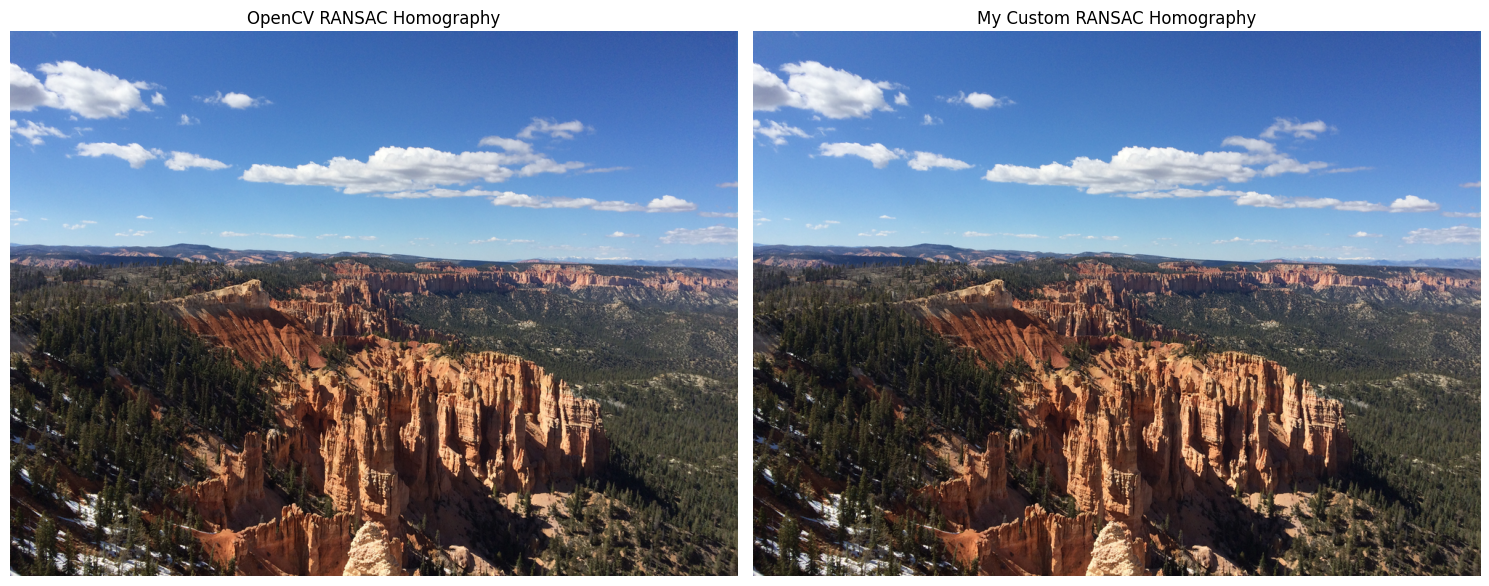

In [18]:
image1 = cv2.imread('bryce_left_03.png')
image2 = cv2.imread('bryce_right_03.png')
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

sift = cv2.SIFT_create()
k_01, f_01 = sift.detectAndCompute(image1, None)
k_02, f_02 = sift.detectAndCompute(image2, None)

# 매칭 수행 (KNN 매칭 + 비율 테스트)
matcher = cv2.BFMatcher(cv2.NORM_L2)
matches = matcher.knnMatch(f_02, f_01, k=2)

good_matches = []
ratio_thresh = 0.7
for m, n in matches:
    if m.distance < ratio_thresh * n.distance:
        good_matches.append(m)

# src_points, dst_points 좌표 추출
src_points = np.float32([k_02[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
dst_points = np.float32([k_01[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

# 이미지 스티칭 함수 정의
def stitch_images(image1, image2, H):
    # height, width 변수 정의
    height, width = image1.shape[:2]
    # 오른쪽 이미지를 H 행렬을 이용해 변형
    result = cv2.warpPerspective(image2, H, (width + 2, height))
    # 왼쪽 이미지 그대로 출력
    result[0:height, 0:width] = image1
    return result


# opencv로 구현한 findHomography 함수로 행렬 계산
opencv_H_ransac, _ = cv2.findHomography(src_points, dst_points, method=cv2.RANSAC, ransacReprojThreshold=5.0)

# opencv 행렬로 이미지 스티칭
stitched_ransac_opencv = stitch_images(image1, image2, opencv_H_ransac)

# 직접 구현한 my_ransac_homography 함수로 행렬 계산
my_H_ransac = my_ransac_homography(good_matches, k_02, k_01)

# 직접 구현한 행렬로 이미지 스티칭
stitched_ransac_custom = stitch_images(image1, image2, my_H_ransac)

# 시각화 (결과 비교)
fig, axes = plt.subplots(1, 2, figsize=(15, 10))

axes[0].imshow(stitched_ransac_opencv)
axes[0].set_title("OpenCV RANSAC Homography")
axes[0].axis('off')

axes[1].imshow(stitched_ransac_custom)
axes[1].set_title("My Custom RANSAC Homography")
axes[1].axis('off')

plt.tight_layout()
plt.show()